# Perceptron with Synthetic Data
This notebook showcases the usage of the Perceptron using synthetic data.

In [1]:
import copy
import os
import warnings

import dotenv
_ = dotenv.load_dotenv()
warnings.filterwarnings('ignore')

import numpy as np
import kagglehub
import keras
import pandas as pd
import statsmodels.api as sm
from matplotlib import gridspec as gridspec
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection._split import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from app.loggers import get_logger
from app.models import Perceptron

logger = get_logger(__name__)

In [2]:
import random

def generate_data(n_samples=100):
    data_x = []
    data_y = []
    
    for _ in range(n_samples // 2):
        # Class 0: Centered around (-2, -2)
        x1 = random.normalvariate(-2, 0.8)
        x2 = random.normalvariate(-2, 0.8)
        data_x.append([x1, x2])
        data_y.append([0.0])
        
        # Class 1: Centered around (2, 2)
        x1 = random.normalvariate(2, 0.8)
        x2 = random.normalvariate(2, 0.8)
        data_x.append([x1, x2])
        data_y.append([1.0])
        
    combined = list(zip(data_x, data_y))
    random.shuffle(combined)
    data_x, data_y = zip(*combined)
    
    return list(data_x), list(data_y)

## Data and Parameters

In [3]:
data_x, data_y = generate_data(600)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2)
learning_rate = 0.1
epochs = 500
batch_size = 32
threshold = 0.5

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

## Training and Results

In [23]:
perceptron = Perceptron(X_train_scaled.tolist(), y_train_scaled.tolist(), activation_function="sigmoid")
perceptron.train(learning_rate, epochs, batch_size)
logger.info("w_current=[%s]", perceptron.w_current)
logger.info("b_current=[%s]", perceptron.b_current)
logger.info("latest_loss=%s", perceptron.epoch_loss_scores[-1])

p_preds = list(map(lambda x: 1 if x >= threshold else 0 , scaler_y.inverse_transform(perceptron.infer(X_test_scaled.tolist()).to_list())))
p_score = r2_score([yi[0] for yi in y_test], p_preds)
logger.info("Perceptron Score(r2): %s", p_score)

2025-12-26 21:35:27,513 - deep_learning.__main__ - INFO - w_current=[3.8391885103363355
4.217674489086175] (997101230.py:3)
2025-12-26 21:35:27,514 - deep_learning.__main__ - INFO - b_current=[-1.3240037982654407] (997101230.py:4)
2025-12-26 21:35:27,515 - deep_learning.__main__ - INFO - latest_loss=0.4915071780438175 (997101230.py:5)
2025-12-26 21:35:27,517 - deep_learning.__main__ - INFO - Perceptron Score(r2): 0.9664335664335665 (997101230.py:9)


## Plots

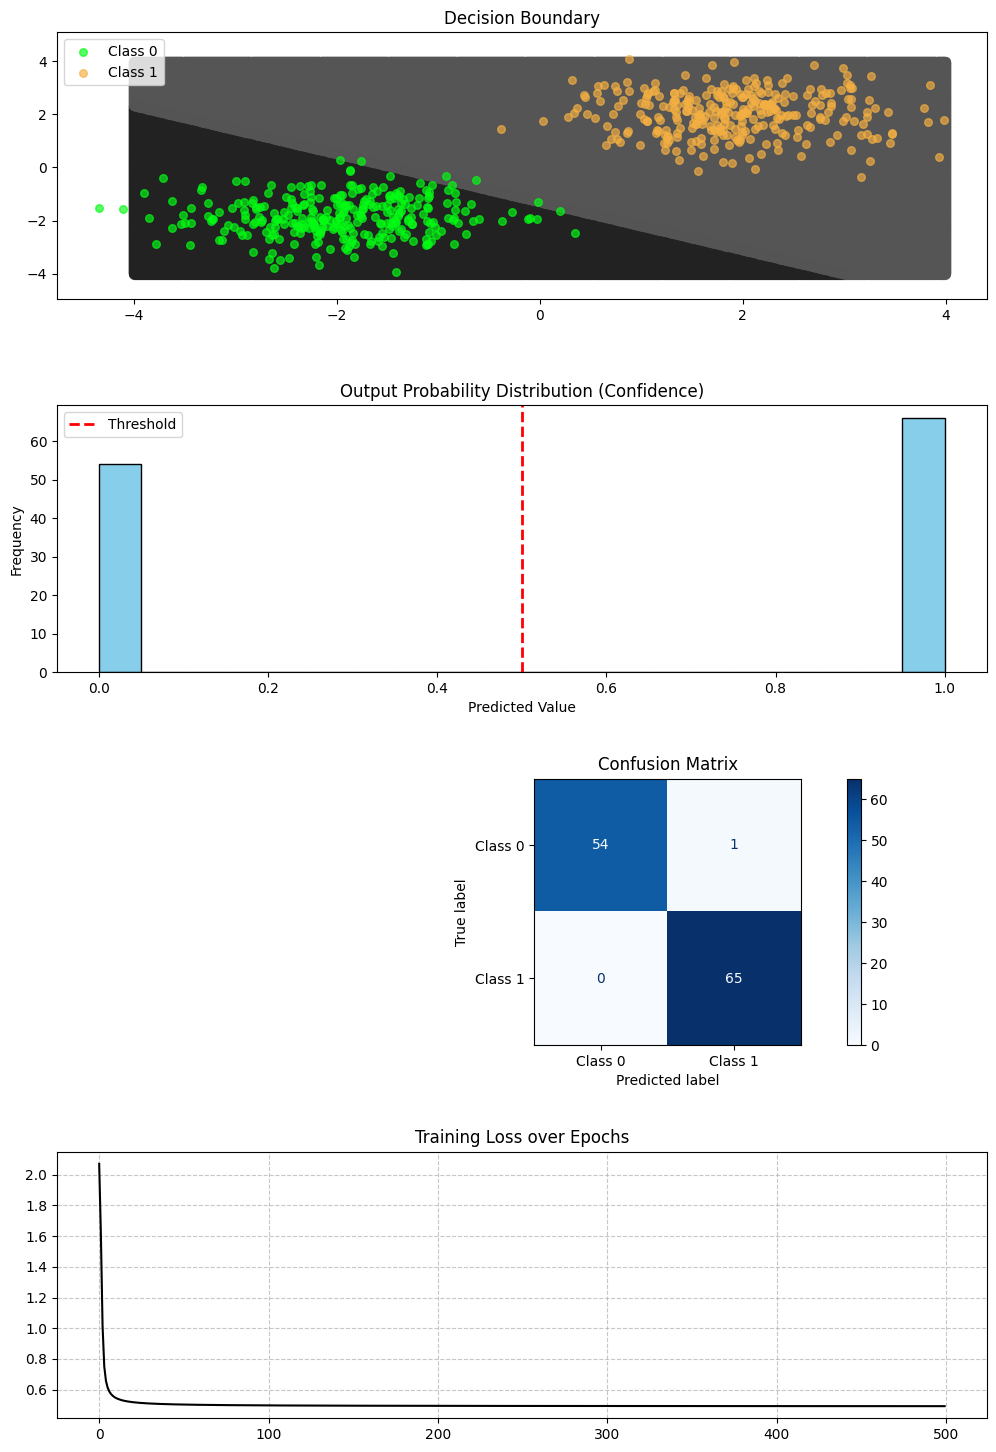

In [24]:
bound_data_x = []
for x1 in range(-400, 400, 1):
    for x2 in range(-400, 400, 1):
        bound_data_x.append([x1/100.0, x2/100.0])
bound_y = list(map(lambda x: 1 if x >= threshold else 0 , scaler_y.inverse_transform(perceptron.infer(scaler.transform(bound_data_x).tolist()).to_list())))
bound_0_x = [bound_data_x[i][0] for i in range(len(bound_y)) if bound_y[i] == 0]
bound_0_y = [bound_data_x[i][1] for i in range(len(bound_y)) if bound_y[i] == 0]
bound_1_x = [bound_data_x[i][0] for i in range(len(bound_y)) if bound_y[i] == 1]
bound_1_y = [bound_data_x[i][1] for i in range(len(bound_y)) if bound_y[i] == 1]

# Separate the data points by class
class_0_x = [data_x[i][0] for i in range(len(data_y)) if data_y[i][0] == 0]
class_0_y = [data_x[i][1] for i in range(len(data_y)) if data_y[i][0] == 0]
class_1_x = [data_x[i][0] for i in range(len(data_y)) if data_y[i][0] == 1]
class_1_y = [data_x[i][1] for i in range(len(data_y)) if data_y[i][0] == 1]


w1 = perceptron.w_current.matrix[0][0]
w2 = perceptron.w_current.matrix[1][0]
bias = perceptron.b_current.matrix[0][0]

x_min = min(class_0_x + class_1_x)
x_max = max(class_0_x + class_1_x)

flat_preds = p_preds
hard_preds = [1 if p >= threshold else 0 for p in flat_preds]
true_labels = [yi[0] for yi in y_test]

fig = plt.figure(figsize=(12, 18))
gs = gridspec.GridSpec(4, 1, hspace=0.4)

# Decision Boundary (Overlay on data)
data_pt = fig.add_subplot(gs[0, :])
data_pt.set_ylim(min(class_0_y + class_1_y) - 1, max(class_0_y + class_1_y) + 1)
data_pt.scatter(bound_0_x, bound_0_y, color="#222222aa", s=50)
data_pt.scatter(bound_1_x, bound_1_y, color="#555555aa", s=50)
data_pt.scatter(class_0_x, class_0_y, color="#03fc13aa", label="Class 0", s=30)
data_pt.scatter(class_1_x, class_1_y, color="#f5b042aa", label="Class 1", s=30)
data_pt.set_title("Decision Boundary")
data_pt.legend()

# Probability Histogram
hist_pt = fig.add_subplot(gs[1, :])
hist_pt.hist(flat_preds, bins=20, color="skyblue", edgecolor="black")
hist_pt.axvline(0.5, color='red', linestyle='dashed', linewidth=2, label='Threshold')
hist_pt.set_title("Output Probability Distribution (Confidence)")
hist_pt.set_xlabel("Predicted Value")
hist_pt.set_ylabel("Frequency")
hist_pt.legend()

# Confusion Matrix
cm_pt = fig.add_subplot(gs[2, :])
cm = confusion_matrix(true_labels, hard_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(ax=cm_pt, cmap='Blues', values_format='d')
cm_pt.set_title("Confusion Matrix")

# Loss Plot
loss_pt = fig.add_subplot(gs[3, :])
loss_pt.plot(perceptron.epoch_loss_scores, label="Training Loss", color="black")
loss_pt.set_title("Training Loss over Epochs")
loss_pt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()